In [103]:
import random
import logging
import pandas as pd
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql import functions as F
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from pyspark.sql.functions import col, concat_ws,when, mean, format_number, count,countDistinct
from pyspark.sql.functions import from_unixtime, date_format, concat_ws,year,lit,rand, unix_timestamp,rand

In [105]:
spark = SparkSession.builder.appName("example") \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.memory", "8g")\
    .config('spark.worker.cleanup.enabled', True)\
    .config("spark.memory.fraction", "0.9") \
    .config("spark.memory.storageFraction", "0.1") \
    .config("spark.driver.maxResultSize", "4g") \
    .getOrCreate()

file_path = "/Users/sudhish/Downloads/archive-7/kindle_reviews.csv"

# ReadING the CSV file into a DataFrame
try:
    df = spark.read.csv(file_path, header=True, inferSchema=True)
except Exception as e:
    print(f"Error reading file: {e}")
    raise

In [106]:
df.show()

+---+----------+-------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|_c0|      asin|helpful|overall|          reviewText|          reviewTime|          reviewerID|        reviewerName|             summary|      unixReviewTime|
+---+----------+-------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|  0|B000F83SZQ| [0, 0]|      5|I enjoy vintage b...|          05 5, 2014|      A1F6404F1VG29J|          Avidreader|  Nice vintage story|          1399248000|
|  1|B000F83SZQ| [2, 2]|      4|This book is a re...|          01 6, 2014|       AN0N05A9LIJEQ|            critters|        Different...|          1388966400|
|  2|B000F83SZQ| [2, 2]|      4|This was a fairly...|          04 4, 2014|       A795DMNCJILA6|                 dot|               Oldie|          1396569600|
|  3|B000F83SZQ| [1, 1]|      5|I'd never read

24/01/07 19:35:09 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , asin, helpful, overall, reviewText, reviewTime, reviewerID, reviewerName, summary, unixReviewTime
 Schema: _c0, asin, helpful, overall, reviewText, reviewTime, reviewerID, reviewerName, summary, unixReviewTime
Expected: _c0 but found: 
CSV file: file:///Users/sudhish/Downloads/archive-7/kindle_reviews.csv


In [107]:

# ReadING the CSV file into a DataFrame
try:
    df = spark.read.csv(file_path, header=True, inferSchema=True)
except Exception as e:
    print(f"Error reading file: {e}")
    raise

# Processing and formatting the dataset
processed_df = df.withColumn(
    "ReviewDate",
    F.date_format(F.from_unixtime(df.unixReviewTime), "dd-MM-yyyy")
)


# Renaming the columns
processed_df = processed_df.withColumnRenamed("asin", "ProductID") \
    .withColumnRenamed("helpful", "Votes") \
    .withColumnRenamed("overall", "Rating") \
    .withColumnRenamed("reviewText", "Review") \
    .withColumnRenamed("reviewerID", "UserID") \
    .withColumnRenamed("reviewerName", "UserName") \
    .withColumnRenamed("summary", "Summary")

In [108]:
processed_df = df.withColumn(
    "Year",
    date_format(from_unixtime(df.unixReviewTime), "yyyy") 
)                                                  #Column name from ReviewDate to Year and filling null values

distinct_years = processed_df.select("Year").distinct().collect()
distinct_years = [row.Year for row in distinct_years]

#Converted the UnixReviewTime to Year Format

processed_df = processed_df.withColumn(
    "Year",
    when(col("Year").isNotNull(), col("Year"))
    .otherwise(lit(random.choice(distinct_years))))

columns_to_drop = ['reviewTime', 'reviewerName', 'reviewerID', 'helpful', 'unixReviewTime']
processed_df = processed_df.drop(*columns_to_drop)


# Drop unnecessary columns
columns_to_drop = ['reviewTime', 'reviewerName', 'reviewerID', 'helpful', 'unixReviewTime']
processed_df = processed_df.drop(*columns_to_drop)

# Rename columns
processed_df = processed_df.withColumnRenamed("asin", "ProductID") \
                           .withColumnRenamed("overall", "Rating") \
                           .withColumnRenamed("reviewText", "Review") \
                           .withColumnRenamed("reviewerID", "UserID") \
                           .withColumnRenamed("summary", "Summary")
processed_df.show(50)


# Remove rows with null values in "Review" and "Summary" columns
processed_df = processed_df.filter((col("Review").isNotNull()) & (col("Summary").isNotNull()) & (col('Rating').isNotNull()))

# Combining Review and Summary Columns
processed_df = processed_df.withColumn("Combined", concat_ws(" ", col("Review"), col("Summary")))
processed_df = processed_df.drop("Summary")
num_rows = processed_df.count()  # Number of rows
num_columns = len(processed_df.columns)  # Number of columns
print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_columns}")
processed_df.show(50)


24/01/07 19:35:16 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , asin, overall, reviewText, summary, unixReviewTime
 Schema: _c0, asin, overall, reviewText, summary, unixReviewTime
Expected: _c0 but found: 
CSV file: file:///Users/sudhish/Downloads/archive-7/kindle_reviews.csv


+---+----------+------+--------------------+--------------------+----+
|_c0| ProductID|Rating|              Review|             Summary|Year|
+---+----------+------+--------------------+--------------------+----+
|  0|B000F83SZQ|     5|I enjoy vintage b...|  Nice vintage story|2014|
|  1|B000F83SZQ|     4|This book is a re...|        Different...|2014|
|  2|B000F83SZQ|     4|This was a fairly...|               Oldie|2014|
|  3|B000F83SZQ|     5|I'd never read an...|  I really liked it.|2014|
|  4|B000F83SZQ|     4|If you like perio...|      Period Mystery|2014|
|  5|B000F83SZQ|     4|A beautiful in-de...|              Review|2014|
|  6|B000F83SZQ|     4|I enjoyed this on...|Nice old fashione...|2014|
|  7|B000F83SZQ|     4|Never heard of Am...|Enjoyable reading...|2014|
|  8|B000FA64PA|     5|Darth Maul workin...|          Darth Maul|2013|
|  9|B000FA64PA|     4|This is a short s...|Not bad, not exce...|2011|
| 10|B000FA64PA|     5|I think I have th...|      Audio and book|2014|
| 11|B

24/01/07 19:35:17 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , asin, overall, reviewText, summary, unixReviewTime
 Schema: _c0, asin, overall, reviewText, summary, unixReviewTime
Expected: _c0 but found: 
CSV file: file:///Users/sudhish/Downloads/archive-7/kindle_reviews.csv


In [109]:
grouped_df = processed_df.groupBy("ProductID").agg(
    format_number(mean(col("Rating")), 2).alias("MeanRating"))
# Show the resulting DataFrame
num_rows = grouped_df.count()
print(f"Total number of Unique IDs : {num_rows}")
grouped_df.show()

Total number of Unique IDs : 61934


+----------+----------+
| ProductID|MeanRating|
+----------+----------+
|B001BUPF62|      4.41|
|B001FB5ST6|      4.35|
|B001YQF0OK|      4.40|
|B002VFPS4U|      4.20|
|B0034KC3TY|      4.00|
|B0035LD84G|      3.29|
|B003X27R26|      4.43|
|B003XT5R6M|      4.31|
|B0044UHVNG|      3.64|
|B0046ZRIMS|      4.57|
|B004CYEV96|      2.75|
|B004EEOHPM|      4.08|
|B004EEOHZW|      4.59|
|B004FV4TO8|      4.50|
|B004GHN8DY|      2.62|
|B004K1ES0I|      4.00|
|B004K1F7US|      4.50|
|B004OEIRNA|      3.66|
|B004QTOEFI|      4.00|
|B004SY664S|      4.80|
+----------+----------+
only showing top 20 rows



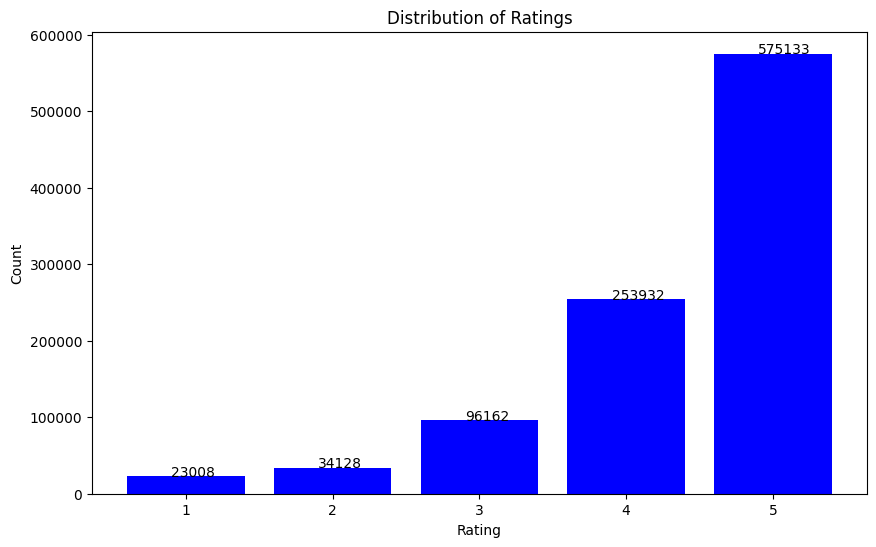

In [110]:
# Bar graph showing distribution of Ratings.
group = processed_df.groupBy("Rating").count()

group_pd = group.toPandas()

# Plotting a bar graph
plt.figure(figsize=(10, 6))
bars = plt.bar(group_pd['Rating'], group_pd['count'], color='blue')

# Adding values on top of the bars
for bar, value in zip(bars, group_pd['count']):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.1, str(value), fontsize=10)

plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings')
plt.show()

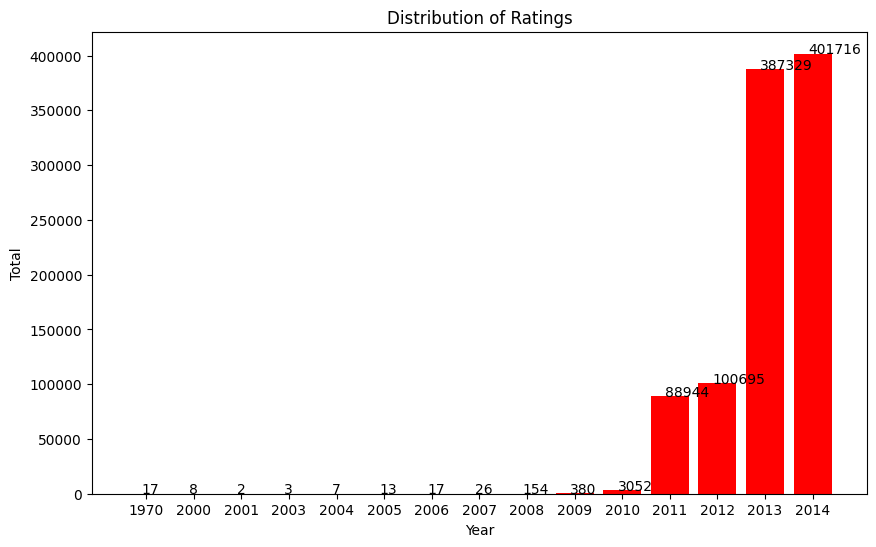

In [102]:
#RATING DISTRIBUTION YEAR BY
group = processed_df.groupBy("Year").count()

group_pd = group.toPandas()
group_pd = group_pd.sort_values('Year')
# Plotting a bar graph
plt.figure(figsize=(10, 6))
bars = plt.bar(group_pd['Year'], group_pd['count'], color='red')

# Adding values on top of the bars
for bar, value in zip(bars, group_pd['count']):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.1, str(value), fontsize=10)

plt.xlabel('Year')
plt.ylabel('Total')
plt.title('Distribution of Ratings')
plt.show()

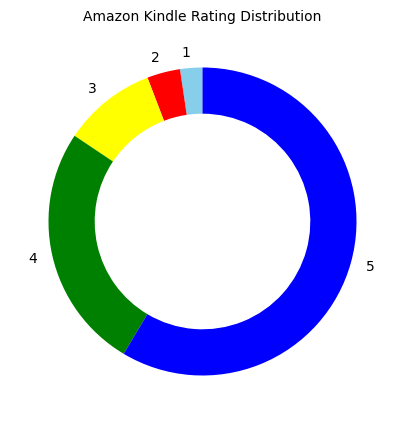

In [65]:
rating_counts = processed_df.groupBy("Rating").count().orderBy("Rating")

try:
    # Convert to Pandas DataFrame
    rating_pd = rating_counts.toPandas()

    # Plotting the donut pie chart
    custom_colors = ['skyblue', 'red', 'yellow', 'green', 'blue']
    plt.figure(figsize=(5, 5))
    plt.pie(rating_pd['count'], labels=rating_pd['Rating'], colors=custom_colors,
             wedgeprops=dict(width=0.3), startangle=90)
    
    # Draw a circle at the center to create a donut chart
    centre_circle = plt.Circle((0,0),0.5,fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)
    
    plt.title('Amazon Kindle Rating Distribution', fontsize=10)
    plt.show()
except AttributeError as e:
    print(f"Error converting to Pandas DataFrame: {e}")

In [66]:
distinct_product_id_count = processed_df.agg(countDistinct("ProductID").alias("DistinctProductID"))
distinct_product_id_count.show()

+-----------------+
|DistinctProductID|
+-----------------+
|            61934|
+-----------------+



In [67]:
rating_summary = processed_df.select("Rating").summary("count", "mean", "stddev", "min", "max")
rating_summary.show()

+-------+------------------+
|summary|            Rating|
+-------+------------------+
|  count|            982363|
|   mean|4.3478256001091244|
| stddev|0.9550487219180104|
|    min|                 1|
|    max|                 5|
+-------+------------------+



In [68]:
#UNDERSAMPLING THE DATA
minority_class_count = processed_df.filter(F.col("Rating") == 3).count()
undersampled_df = processed_df.filter(F.col("Rating") == 5).sample(False, minority_class_count / processed_df.filter(F.col("Rating") == 5).count())
undersampled_df = undersampled_df.unionAll(processed_df.filter(F.col("Rating") != 5)).orderBy(F.rand())
minority_class_count_4 = undersampled_df.filter(F.col("Rating") == 2).count()
undersampled_df_4 = undersampled_df.filter(F.col("Rating") == 4).sample(False, minority_class_count_4 / undersampled_df.filter(F.col("Rating") == 4).count())
undersampled_df_4 = undersampled_df_4.unionAll(undersampled_df.filter(F.col("Rating") != 4)).orderBy(F.rand())

#count of each RATING class in the undersampled dataset
undersampled_df_4.groupBy("Rating").count().show()


+------+-----+
|Rating|count|
+------+-----+
|     4|33818|
|     1|23008|
|     3|96162|
|     5|96707|
|     2|34128|
+------+-----+



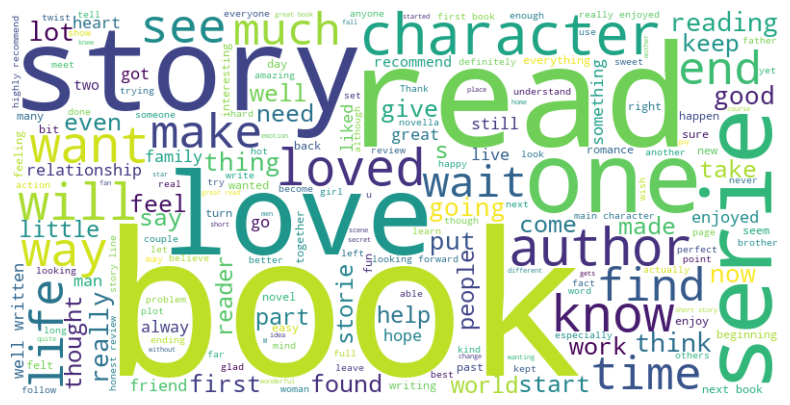

In [43]:
filtered_df = undersampled_df_4.filter(col("Rating") > 3)

# Tokenization and Preprocessing 
processed_text = " ".join(filtered_df.select("Review").rdd.flatMap(lambda x: x).collect())

# Generate Word Cloud
poitive_wordcloud = WordCloud(width=800, height=400, background_color="white").generate(processed_text)

# Displaying the Word Cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(poitive_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

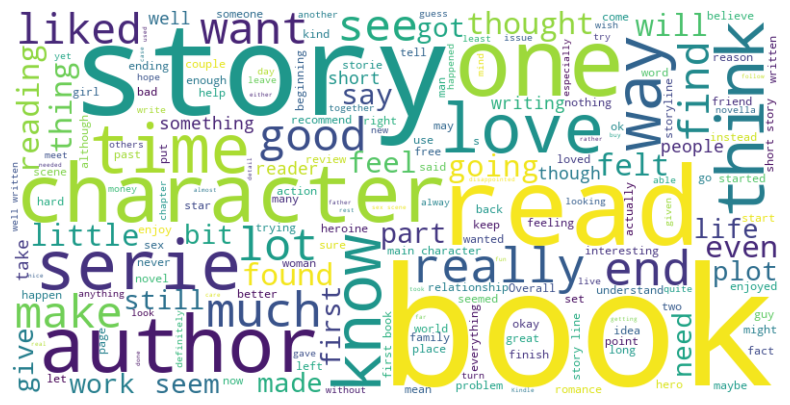

In [44]:
filtered_df_1 = undersampled_df_4.filter(col("Rating")<4)

# Tokenization and Preprocessing
processed_text_1 = " ".join(filtered_df_1.select("Review").rdd.flatMap(lambda x: x).collect())

# Generate Word Cloud
negative_wordcloud = WordCloud(width=800, height=400, background_color="white").generate(processed_text_1)

# Displaying the Negative Word Cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(negative_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [45]:
# WITH POSITIVE OR NEGATIVE 

#CONVERTING RATING TO TWO VARIABLES FOR BETTER ACCURACY AND PREDICTION
#1- Positive; 0-Negative

undersampled_df_4 = undersampled_df_4.withColumn("New_Rating", when(col("Rating") > 3, 1).otherwise(0))
undersampled_df_4=undersampled_df_4.toPandas()

vectorizer = TfidfVectorizer(max_features=9000, stop_words='english')
X = vectorizer.fit_transform(undersampled_df_4['Combined'])
y = undersampled_df_4['New_Rating']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=80)

# Logistic Regression
logistic_model = LogisticRegression(max_iter=1000, random_state=80)

# Hyperparameter tuning using GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2'], 'solver': ['liblinear']}
grid_search = GridSearchCV(logistic_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

#the best model from the grid search
best_logistic_model = grid_search.best_estimator_

# Predictions
logistic_predictions = best_logistic_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, logistic_predictions)
conf_matrix = confusion_matrix(y_test, logistic_predictions)
classification_rep = classification_report(y_test, logistic_predictions)

# Display evaluation metrics
print(f"Logistic Regression Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{classification_rep}")

24/01/07 10:52:09 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , asin, overall, reviewText, summary, unixReviewTime
 Schema: _c0, asin, overall, reviewText, summary, unixReviewTime
Expected: _c0 but found: 
CSV file: file:///Users/sudhish/Downloads/archive-7/kindle_reviews.csv
24/01/07 10:52:10 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , asin, overall, reviewText, summary, unixReviewTime
 Schema: _c0, asin, overall, reviewText, summary, unixReviewTime
Expected: _c0 but found: 
CSV file: file:///Users/sudhish/Downloads/archive-7/kindle_reviews.csv
24/01/07 10:52:11 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , asin, overall, reviewText, summary, unixReviewTime
 Schema: _c0, asin, overall, reviewText, summary, unixReviewTime
Expected: _c0 but found: 
CSV file: file:///Users/sudhish/Downloads/archive-7/kindle_reviews.csv
24/01/07 10:52:12 WARN CSVHeaderChecker: CSV header does not conform to the 

Logistic Regression Accuracy: 0.8501982204211083
Confusion Matrix:
[[26393  4214]
 [ 4288 21860]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.86      0.86     30607
           1       0.84      0.84      0.84     26148

    accuracy                           0.85     56755
   macro avg       0.85      0.85      0.85     56755
weighted avg       0.85      0.85      0.85     56755



In [55]:
# RATINGS 1-5
"""
# WE CAN ALSO USE THE RANDOM FOREST CLASSIFIER WITH BETTER TUNING OF THE MODEL AND MORE NUMBER OF DECISION TREES


undersampled_df_4=undersampled_df_4.toPandas()
vectorizer = TfidfVectorizer(max_features=9000, stop_words='english')
X = vectorizer.fit_transform(undersampled_df_4['Combined'])
y = undersampled_df_4['Rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=80)

# Random Forest Classifier
random_forest_model = RandomForestClassifier(n_estimators=200, random_state=80)

# Train the model
random_forest_model.fit(X_train, y_train)

# Predictions
rf_predictions = random_forest_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, rf_predictions)
conf_matrix = confusion_matrix(y_test, rf_predictions)
classification_rep = classification_report(y_test, rf_predictions)

# Display evaluation metrics
print(f"Random Forest Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{classification_rep}")

"""

undersampled_df_4=undersampled_df_4.toPandas()
vectorizer = TfidfVectorizer(max_features=9000, stop_words='english')
X = vectorizer.fit_transform(undersampled_df_4['Combined'])
y = undersampled_df_4['Rating']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=80)

# Logistic Regression
logistic_model = LogisticRegression(max_iter=1000, random_state=80)

# Hyperparameter tuning using GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2'], 'solver': ['liblinear']}
grid_search = GridSearchCV(logistic_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best model from the grid search
best_logistic_model = grid_search.best_estimator_

# Predictions
logistic_predictions = best_logistic_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, logistic_predictions)
conf_matrix = confusion_matrix(y_test, logistic_predictions)
classification_rep = classification_report(y_test, logistic_predictions)

# Display evaluation metrics
print(f"Logistic Regression Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{classification_rep}")

24/01/07 11:10:46 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , asin, overall, reviewText, summary, unixReviewTime
 Schema: _c0, asin, overall, reviewText, summary, unixReviewTime
Expected: _c0 but found: 
CSV file: file:///Users/sudhish/Downloads/archive-7/kindle_reviews.csv
24/01/07 11:10:47 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , asin, overall, reviewText, summary, unixReviewTime
 Schema: _c0, asin, overall, reviewText, summary, unixReviewTime
Expected: _c0 but found: 
CSV file: file:///Users/sudhish/Downloads/archive-7/kindle_reviews.csv
24/01/07 11:10:48 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , asin, overall, reviewText, summary, unixReviewTime
 Schema: _c0, asin, overall, reviewText, summary, unixReviewTime
Expected: _c0 but found: 
CSV file: file:///Users/sudhish/Downloads/archive-7/kindle_reviews.csv
24/01/07 11:10:49 WARN CSVHeaderChecker: CSV header does not conform to the 

Logistic Regression Accuracy: 0.6273768957785272
Confusion Matrix:
[[ 2248   804  1258     4   279]
 [  941  1447  4047    14   479]
 [  360   750 15094   199  2778]
 [   27    27  3026   213  3613]
 [   50    40  2215   194 16532]]
Classification Report:
              precision    recall  f1-score   support

           1       0.62      0.49      0.55      4593
           2       0.47      0.21      0.29      6928
           3       0.59      0.79      0.67     19181
           4       0.34      0.03      0.06      6906
           5       0.70      0.87      0.77     19031

    accuracy                           0.63     56639
   macro avg       0.54      0.48      0.47     56639
weighted avg       0.58      0.63      0.57     56639



In [70]:
# WITH POSITIVE, NEGATIVE OR NEUTRAL


#CONVERTING RATING TO THREE VARIABLES FOR BETTER ACCURACY AND PREDICTION
#1- Positive; 2-Negative; 0-Neutral

undersampled_df_4 = undersampled_df_4.withColumn("New_Rating", when(col("Rating") > 3, 1).when(col("Rating") < 3,2).otherwise(0))
undersampled_df_4=undersampled_df_4.toPandas()
vectorizer = TfidfVectorizer(max_features=9000, stop_words='english')
X = vectorizer.fit_transform(undersampled_df_4['Combined'])
y = undersampled_df_4['New_Rating']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=80)

# Logistic Regression
logistic_model = LogisticRegression(max_iter=1000, random_state=60)

# Hyperparameter tuning using GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2'], 'solver': ['liblinear']}
grid_search = GridSearchCV(logistic_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best model from the grid search
best_logistic_model = grid_search.best_estimator_

# Predictions
logistic_predictions = best_logistic_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, logistic_predictions)
conf_matrix = confusion_matrix(y_test, logistic_predictions)
classification_rep = classification_report(y_test, logistic_predictions)

# Display evaluation metrics
print(f"Logistic Regression Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{classification_rep}")

24/01/07 16:23:26 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , asin, overall, reviewText, summary, unixReviewTime
 Schema: _c0, asin, overall, reviewText, summary, unixReviewTime
Expected: _c0 but found: 
CSV file: file:///Users/sudhish/Downloads/archive-7/kindle_reviews.csv
24/01/07 16:23:27 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , asin, overall, reviewText, summary, unixReviewTime
 Schema: _c0, asin, overall, reviewText, summary, unixReviewTime
Expected: _c0 but found: 
CSV file: file:///Users/sudhish/Downloads/archive-7/kindle_reviews.csv
24/01/07 16:23:28 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , asin, overall, reviewText, summary, unixReviewTime
 Schema: _c0, asin, overall, reviewText, summary, unixReviewTime
Expected: _c0 but found: 
CSV file: file:///Users/sudhish/Downloads/archive-7/kindle_reviews.csv
24/01/07 16:23:29 WARN CSVHeaderChecker: CSV header does not conform to the 

Logistic Regression Accuracy: 0.7468626621545403
Confusion Matrix:
[[12225  4819  2322]
 [ 2694 22924   395]
 [ 3215   917  7225]]
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.63      0.65     19366
           1       0.80      0.88      0.84     26013
           2       0.73      0.64      0.68     11357

    accuracy                           0.75     56736
   macro avg       0.73      0.72      0.72     56736
weighted avg       0.74      0.75      0.74     56736



In [111]:
spark.stop()